In [10]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

## Define utility functions

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.51MB/s]


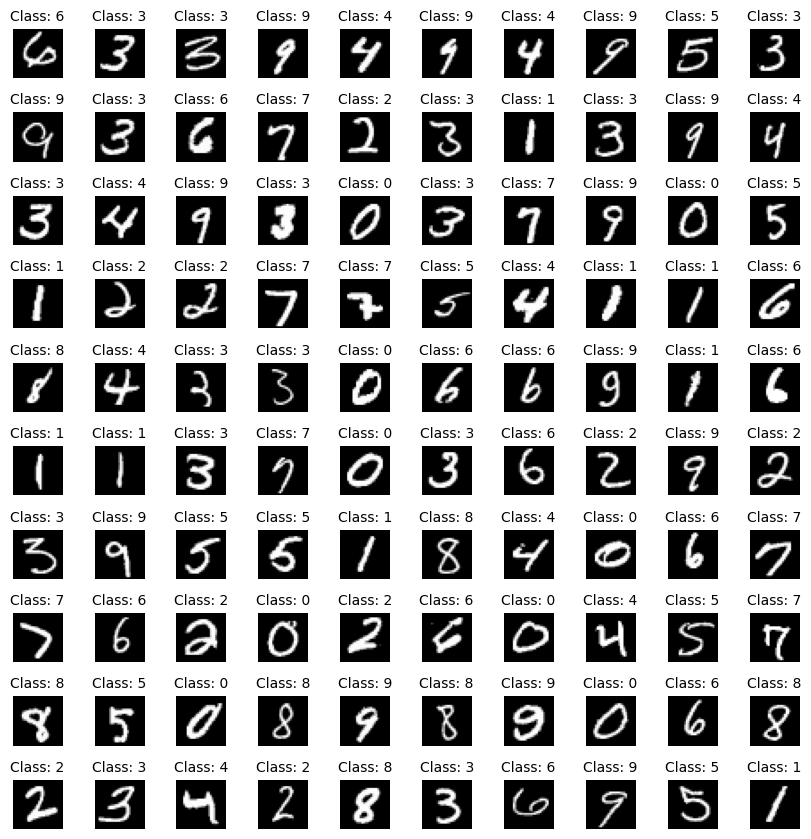

In [4]:
def show_dataset_sample(sample_size: int = 100):
  loader = DataLoader(dataset, batch_size=100, shuffle=True)
  x, y = next(iter(loader))
  show_images(x, y)

show_dataset_sample()

## Select a device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cpu


## Define the model

In [55]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.


In [6]:
# TODO: Define your model(s) and loss function(s) here.
# This version supports CONDITIONAL PixelCNN using class labels y.

class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution for autoregressive PixelCNN.
    Mask type 'A' for first layer, 'B' for others.
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True):
        super().__init__(in_channels, out_channels, kernel_size,
                         stride, padding, bias=bias)

        assert mask_type in ['A', 'B'], "mask_type must be 'A' or 'B'"

        # create mask
        self.register_buffer('mask', torch.ones_like(self.weight))
        # kernel height and wifth
        kh, kw = self.weight.shape[2], self.weight.shape[3]
        # center pixel of the kernel
        yc, xc = kh // 2, kw // 2

        # Zero-out invalid future pixels
        self.mask[:, :, yc +1:, :] = 0
        self.mask[:, :, yc, xc + 1:] = 0
        if mask_type == 'A':
            self.mask[:, :, yc, xc] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class ConditionalPixelCNN(nn.Module):
    def __init__(
        self,
        in_channels=1,          # MNIST grayscale -> 1
        hidden_channels=64,
        kernel_size=7,
        num_layers=7,
        num_classes=256,        # discrete pixel intensities
        num_labels=10           # MNIST: 10 digits
    ):
        super().__init__()

        # Label embedding
        self.label_emb = nn.Embedding(num_labels, hidden_channels)

        padding = kernel_size // 2
        self.layers = nn.ModuleList()

        # First layer: Mask-A
        self.layers.append(MaskedConv2d('A', in_channels, hidden_channels, kernel_size, padding=padding))

        # Hidden layers: Mask-B
        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size, padding=padding))

        # Final layer: outputs logits per pixel
        self.final_layer = MaskedConv2d('B', hidden_channels, num_classes, kernel_size=1)

        self.relu = nn.ReLU()

    def forward(self, x, y):
        """
        x: [B, C, H, W]  pixel values float 0-1
        y: [B]  int64 labels (0..num_labels-1)
        returns: [B, num_classes, H, W] logits for discrete pixel intensities
        """
        B, _, H, W = x.shape
        y_emb = self.label_emb(y)[:, :, None, None]  # [B, hidden_channels, 1, 1]
        num_layers = len(self.layers)
        inject_layers = {0, num_layers // 2, num_layers - 1}

        out = x
        for i, layer in enumerate(self.layers):
            out = layer(out)
            out = self.relu(out)
            # inject label after every conv layer
            if i in inject_layers:
                out = out + y_emb
            out = out + y_emb

        out = self.final_layer(out)
        #out = out + y_emb  # inject label even in final logits
        return out


## Define Hyperparameters

In [7]:
# TODO: Define the hyperparameters here.
pixelcnn_hparams = {
    "in_channels": 1,         # MNIST grayscale images
    "hidden_channels": 64,    # Number of feature maps per layer
    "kernel_size": 7,         # Convolution kernel size
    "num_layers": 15,          # First layer (mask A) + hidden B layers + final layer
    "num_classes": 256,       # Pixel values 0-255
    "num_labels": 10,         # MNIST has 10 classes
    "batch_size": 64,         # Batch size
    "lr": 1e-3,               # Learning rate
    "num_epochs": 25,         # Number of training epochs
    "device": device          # Computation device
}


## Instantiate models and optimizers

In [8]:
# TODO: Instantiate the models and optimizers here.

model = ConditionalPixelCNN(
    in_channels=pixelcnn_hparams["in_channels"],
    hidden_channels=pixelcnn_hparams["hidden_channels"],
    kernel_size=pixelcnn_hparams["kernel_size"],
    num_layers=pixelcnn_hparams["num_layers"],
    num_classes=pixelcnn_hparams["num_classes"],
    num_labels=pixelcnn_hparams["num_labels"],
).to(pixelcnn_hparams["device"])

# Loss: cross-entropy over 256 pixel values
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=pixelcnn_hparams["lr"])

print("Conditional PixelCNN model, loss, and optimizer are ready.")


Conditional PixelCNN model, loss, and optimizer are ready.


## Train the model

In [59]:
# TODO: Write the code to train the model here


In [9]:
# DataLoader for training
train_loader = DataLoader(dataset, batch_size=pixelcnn_hparams["batch_size"], shuffle=True)

num_epochs = pixelcnn_hparams["num_epochs"]
device = pixelcnn_hparams["device"]
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for x, y_batch in train_loader:   # x (images) -> y (labels)
        x = x.to(device)              # [B, 1, 28, 28]
        y_batch = y_batch.to(device)  # [B]
        optimizer.zero_grad()
        output = model(x, y_batch)
        loss = loss_function(output, (x * 255).long().squeeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")


KeyboardInterrupt: 

## [Optional] Save and/or load the model

In [ ]:
## Optional TODO: Save the model if you want to store your work on disk and load it later

## Write the generation function

In [16]:
# TODO: Rewrite the following function

# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32
@torch.no_grad()
def generate(y: torch.Tensor) -> torch.Tensor:
    """
    Generate MNIST images conditioned on class labels y using PixelCNN.

    Args:
        y: Tensor of shape [B], class labels (int64) on CPU
    Returns:
        Tensor of shape [B, 1, 28, 28], float32, values in [0,1]
    """
    model.eval()
    device = next(model.parameters()).device
    y = y.to(device)
    batch_size = y.shape[0]

    # Initialize empty images
    images = torch.zeros((batch_size, 1, 28, 28), device=device)

    # Pixel-by-pixel generation
    for i in range(28):
        for j in range(28):
            # Forward pass with conditional labels
            out = model(images, y)              # [B, 256, 28, 28]

            # Compute probability distribution for current pixel
            probs = F.softmax(out[:, :, i, j], dim=-1)  # [B, 256]

            # Sample pixel values
            pixel_sample = torch.multinomial(probs, 1).squeeze(1)  # [B]

            # Assign sampled pixel (normalize to [0,1])
            images[:, 0, i, j] = pixel_sample.float() / 255.0

    return images.cpu()


## Generate some images and display them

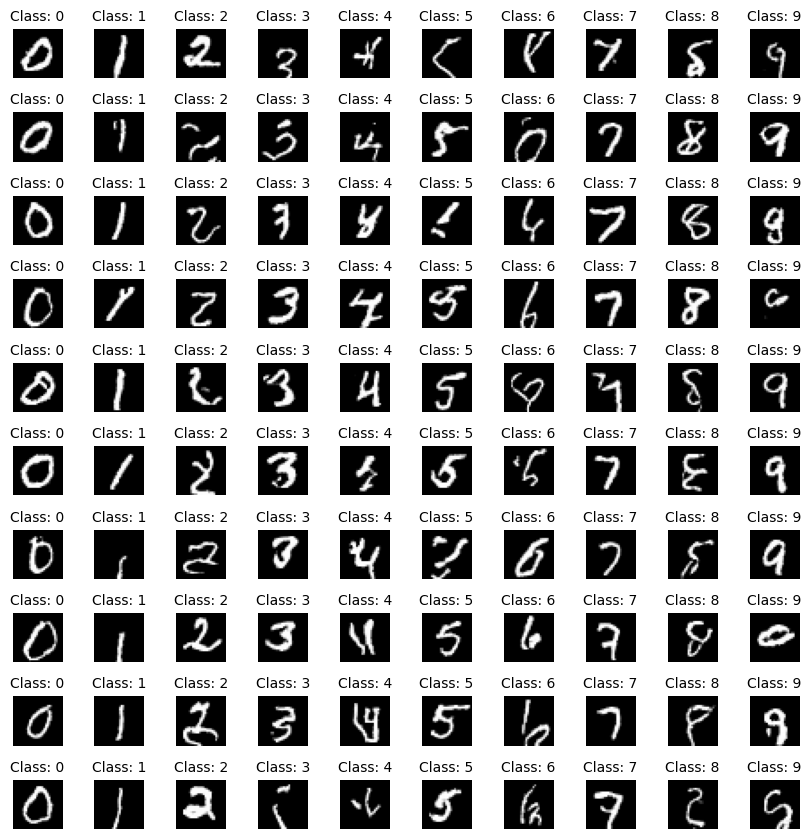

In [17]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).